In [1]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation, Flatten
from keras.layers import Conv1D, LSTM, Dropout, Bidirectional,LayerNormalization,SimpleRNN
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./data/stock.csv', index_col=0)

In [3]:
df.columns

Index(['종목코드', '종목명', '거래량', '시가', '고가', '저가', '종가'], dtype='object')

In [4]:
df = df[df['종목명']=='삼성전자']

In [5]:
df = df[['시가','고가','저가','종가']]

In [6]:
df

,시가,고가,저가,종가
일자,,,,
20210601,80500,81300,80100,80600
20210602,80400,81400,80300,80800
20210603,81300,83000,81100,82800
20210604,82700,82700,81500,82200
20210607,82700,82800,81600,81900
...,...,...,...,...
20230523,68500,68700,68100,68400
20230524,68100,68700,68000,68500
20230525,69900,70000,68700,68800


In [7]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

df = MinMaxScaler(df)

In [8]:
dfx = df[['시가','고가','저가']]
dfy = df[['종가']]

dfx.columns = ['Open','High','Low']
dfy.columns = [['Close']]

In [9]:
dfy

,Close
일자,
20210601,0.924092
20210602,0.930693
20210603,0.996700
20210604,0.976898
20210607,0.966997
...,...
20230523,0.521452
20230524,0.524752
20230525,0.534653


In [10]:
time_step = 5
step = 1

def create_dataset(X, y, time_step, step):
    Xs, ys = [], []

    for i in range(0, len(X) - time_step, step):
        v = X.iloc[i : (i + time_step)].values
        labels = y.iloc[i + time_step]

        Xs.append(v)
        ys.append(labels)

    return np.array(Xs), np.array(ys)

In [11]:
X, y = create_dataset(dfx, dfy, time_step, step)

X.shape

(489, 5, 3)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((327, 5, 3), (162, 5, 3), (327, 1), (162, 1))

In [13]:
model = Sequential()
model.add(Conv1D(16, 3,input_shape = (X.shape[1:]), activation='relu'))
model.add(Conv1D(8, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 16)             160       
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 8)              392       
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 561 (2.19 KB)
Trainable params: 561 (2.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [15]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.33, shuffle=False)

Epoch 1/500
7/7 [==============================] - 3s 125ms/step - loss: 0.2297 - mae: 0.4469 - val_loss: 0.0066 - val_mae: 0.0649
Epoch 2/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0222 - mae: 0.1133 - val_loss: 0.0092 - val_mae: 0.0882
Epoch 3/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0206 - mae: 0.1346 - val_loss: 0.0153 - val_mae: 0.1167
Epoch 4/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0171 - mae: 0.1187 - val_loss: 0.0062 - val_mae: 0.0696
Epoch 5/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0025 - mae: 0.0376 - val_loss: 0.0024 - val_mae: 0.0413
Epoch 6/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0052 - mae: 0.0603 - val_loss: 0.0024 - val_mae: 0.0410
Epoch 7/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0036 - mae: 0.0470 - val_loss: 0.0037 - val_mae: 0.0524
Epoch 8/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0024 - mae: 0.0

7/7 [==============================] - 0s 15ms/step - loss: 0.0019 - mae: 0.0325 - val_loss: 0.0022 - val_mae: 0.0402
Epoch 64/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0019 - mae: 0.0325 - val_loss: 0.0022 - val_mae: 0.0401
Epoch 65/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0019 - mae: 0.0324 - val_loss: 0.0022 - val_mae: 0.0399
Epoch 66/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0019 - mae: 0.0324 - val_loss: 0.0022 - val_mae: 0.0398
Epoch 67/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0019 - mae: 0.0324 - val_loss: 0.0022 - val_mae: 0.0397
Epoch 68/500
7/7 [==============================] - 0s 29ms/step - loss: 0.0019 - mae: 0.0323 - val_loss: 0.0021 - val_mae: 0.0395
Epoch 69/500
7/7 [==============================] - 0s 27ms/step - loss: 0.0019 - mae: 0.0323 - val_loss: 0.0021 - val_mae: 0.0394
Epoch 70/500
7/7 [==============================] - 0s 57ms/step - loss: 0.0019 - mae: 0.0323 - 

7/7 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0309 - val_loss: 0.0017 - val_mae: 0.0349
Epoch 126/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0309 - val_loss: 0.0017 - val_mae: 0.0349
Epoch 127/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0309 - val_loss: 0.0017 - val_mae: 0.0348
Epoch 128/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0309 - val_loss: 0.0017 - val_mae: 0.0348
Epoch 129/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0308 - val_loss: 0.0017 - val_mae: 0.0348
Epoch 130/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0017 - mae: 0.0308 - val_loss: 0.0017 - val_mae: 0.0347
Epoch 131/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0017 - mae: 0.0308 - val_loss: 0.0017 - val_mae: 0.0347
Epoch 132/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.

7/7 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0297 - val_loss: 0.0015 - val_mae: 0.0328
Epoch 188/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 0.0015 - val_mae: 0.0328
Epoch 189/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 0.0015 - val_mae: 0.0327
Epoch 190/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 0.0015 - val_mae: 0.0327
Epoch 191/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0296 - val_loss: 0.0015 - val_mae: 0.0327
Epoch 192/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0015 - mae: 0.0296 - val_loss: 0.0015 - val_mae: 0.0326
Epoch 193/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0015 - mae: 0.0296 - val_loss: 0.0015 - val_mae: 0.0326
Epoch 194/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0015 - mae: 0.

7/7 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0286 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 250/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0286 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 251/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 252/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 0.0014 - val_mae: 0.0312
Epoch 253/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 0.0014 - val_mae: 0.0312
Epoch 254/500
7/7 [==============================] - 0s 26ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 0.0014 - val_mae: 0.0312
Epoch 255/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 0.0014 - val_mae: 0.0312
Epoch 256/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.

7/7 [==============================] - 0s 13ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 0.0013 - val_mae: 0.0302
Epoch 312/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 0.0013 - val_mae: 0.0302
Epoch 313/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0013 - val_mae: 0.0302
Epoch 314/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0013 - val_mae: 0.0301
Epoch 315/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0013 - val_mae: 0.0301
Epoch 316/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0013 - val_mae: 0.0301
Epoch 317/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0013 - val_mae: 0.0301
Epoch 318/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.

7/7 [==============================] - 0s 17ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0297
Epoch 374/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0297
Epoch 375/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0297
Epoch 376/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0297
Epoch 377/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0297
Epoch 378/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0297
Epoch 379/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0297
Epoch 380/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0013 - mae: 0.

7/7 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0270 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 436/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0270 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 437/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0270 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 438/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0270 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 439/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0270 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 440/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 441/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 442/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.

7/7 [==============================] - 0s 11ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 0.0013 - val_mae: 0.0303
Epoch 498/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.0265 - val_loss: 0.0013 - val_mae: 0.0301
Epoch 499/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0012 - mae: 0.0265 - val_loss: 0.0013 - val_mae: 0.0299
Epoch 500/500
7/7 [==============================] - 0s 23ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0013 - val_mae: 0.0298


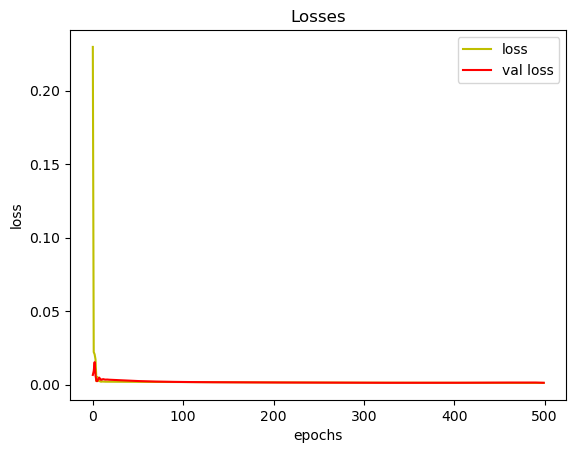

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
y_pred = model.predict(X_test)

6/6 [==============================] - 0s 3ms/step


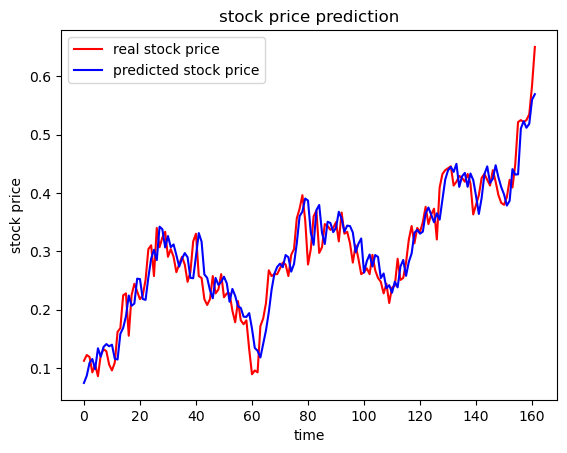

In [18]:
plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()